# Controlnet

Controlnet is a variant of diffusion models that allows to add additional constraints during the generation process. Here we show an example adapted from https://huggingface.co/blog/controlnet that uses image contours as "basis" from which to start generating a new image.

In [1]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.6 MB/s eta 0:00:00


In [ ]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image
from diffusers import UniPCMultistepScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

Here you can load your favorite image:

In [114]:
image = skimage.io.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/2/29/ParusCaeruleus.jpg/480px-ParusCaeruleus.jpg')

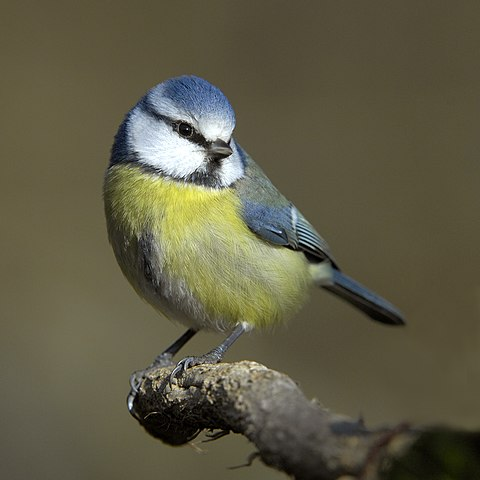

In [122]:
import PIL
PIL.Image.fromarray(image)

We now transform the image into contours:

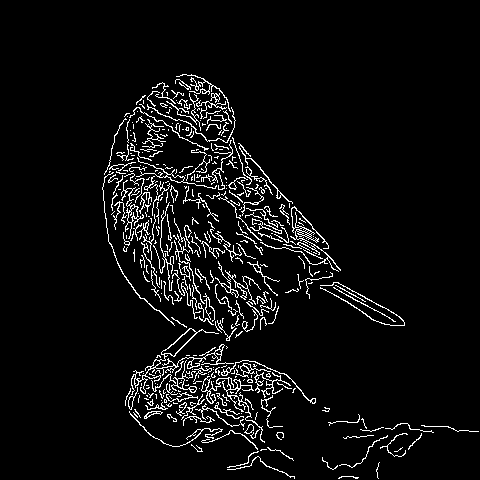

In [115]:
import skimage
import PIL
canny_image = skimage.feature.canny(skimage.color.rgb2gray(image))
canny_image = (255*canny_image).astype(np.uint8)

canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = PIL.Image.fromarray(canny_image)

canny_image


We load the model:

In [72]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Finally we generate the image, using specific prompts to turn the contours into an object. Here we use a realistic and random prompt:

In [123]:
generator = [torch.Generator(device="cpu").manual_seed(4) for i in range(2)]

output = pipe(
    ['Red bird', 'Tulips'],
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 2,
    generator=generator,
    num_inference_steps=50,
)

  0%|          | 0/50 [00:00<?, ?it/s]

And we look at the output:

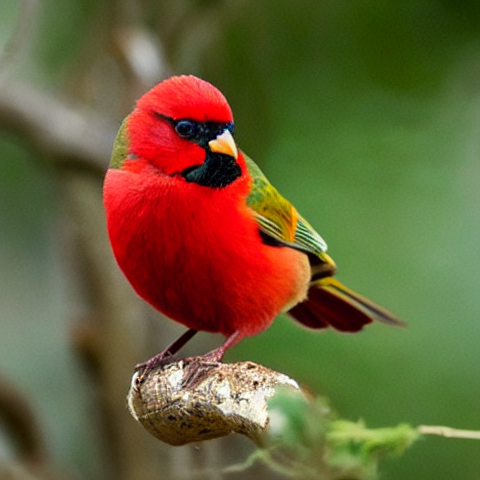

In [124]:
output.images[0]

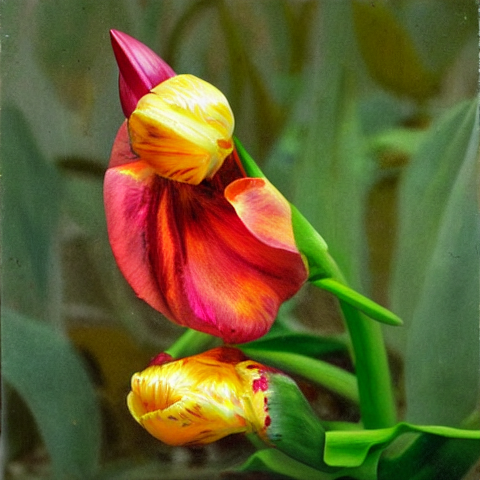

In [125]:
output.images[1]